In [ ]:
# Finetune BERT model for classification task on IMDB dataset

In [1]:
! pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.8 MB/s eta 0:00:00


In [2]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
checkpoint='bert-base-uncased'
tokenizer=AutoTokenizer.from_pretrained(checkpoint)

In [4]:
train=list(df['sentence'])

labels=list(df['label'])
print(train,labels)
tokens=tokenizer(train, padding=True, truncation=True, max_length=512,return_tensors='pt')

['The movie was fantastic!', "I didn't like the ending.", 'The acting was mediocre.', 'The food at the restaurant was delicious.', 'The service was terrible.', 'The weather today is just okay.', 'I absolutely loved the book.', 'The product was a complete waste of money.', 'The presentation was average.'] [1, 0, 0, 1, 0, 0, 1, 0, 0]


In [5]:
tokens

{'input_ids': tensor([[  101,  1996,  3185,  2001, 10392,   999,   102,     0,     0,     0,
             0],
        [  101,  1045,  2134,  1005,  1056,  2066,  1996,  4566,  1012,   102,
             0],
        [  101,  1996,  3772,  2001, 19960,  3695, 16748,  1012,   102,     0,
             0],
        [  101,  1996,  2833,  2012,  1996,  4825,  2001, 12090,  1012,   102,
             0],
        [  101,  1996,  2326,  2001,  6659,  1012,   102,     0,     0,     0,
             0],
        [  101,  1996,  4633,  2651,  2003,  2074,  3100,  1012,   102,     0,
             0],
        [  101,  1045,  7078,  3866,  1996,  2338,  1012,   102,     0,     0,
             0],
        [  101,  1996,  4031,  2001,  1037,  3143,  5949,  1997,  2769,  1012,
           102],
        [  101,  1996,  8312,  2001,  2779,  1012,   102,     0,     0,     0,
             0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0

In [11]:
! pip install torch

In [13]:
import torch
tokens['labels']=torch.tensor(labels)
tokens['input_ids']

tensor([[  101,  1996,  3185,  2001, 10392,   999,   102,     0,     0,     0,
             0],
        [  101,  1045,  2134,  1005,  1056,  2066,  1996,  4566,  1012,   102,
             0],
        [  101,  1996,  3772,  2001, 19960,  3695, 16748,  1012,   102,     0,
             0],
        [  101,  1996,  2833,  2012,  1996,  4825,  2001, 12090,  1012,   102,
             0],
        [  101,  1996,  2326,  2001,  6659,  1012,   102,     0,     0,     0,
             0],
        [  101,  1996,  4633,  2651,  2003,  2074,  3100,  1012,   102,     0,
             0],
        [  101,  1045,  7078,  3866,  1996,  2338,  1012,   102,     0,     0,
             0],
        [  101,  1996,  4031,  2001,  1037,  3143,  5949,  1997,  2769,  1012,
           102],
        [  101,  1996,  8312,  2001,  2779,  1012,   102,     0,     0,     0,
             0]])

In [14]:
from transformers import AutoModelForSequenceClassification
model=AutoModelForSequenceClassification.from_pretrained(checkpoint)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
from transformers import AdamW
optimizer = AdamW(model.parameters(), lr=1e-5)  # Adjust learning rate as needed
criterion = torch.nn.CrossEntropyLoss()
# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
num_epochs = 3  # Adjust as needed
batch_size = 3
for i in range(num_epochs):
    model.train()
    total_loss=0
    for j in range(0,len(labels),batch_size):
        input_ids=tokens['input_ids'][j:j+batch_size].to(device)
        attention_mask=tokens['attention_mask'][j:j+batch_size].to(device)
        labels=tokens['labels'][j:j+batch_size].to(device)
        optimizer.zero_grad()
        output=model(input_ids=input_ids,attention_mask=attention_mask,labels=labels)
        loss=output.loss
        total_loss=total_loss+loss.item()
        loss.backward()
        optimizer.step()
    avg_loss = total_loss / (len(labels) / batch_size)
    print(f'Epoch {i + 1}, Loss: {avg_loss:.4f}')

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Loss: 1.7601
Epoch 2, Loss: 0.6017
Epoch 3, Loss: 0.5819


In [16]:
model_save_path = "bert_classifier_model.pth"
torch.save(model.state_dict(), model_save_path)


In [17]:
!pip install transformers

In [18]:
! pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00


In [19]:
from datasets import load_dataset

imdb_dataset = load_dataset("imdb")
imdb_dataset

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [20]:
imdb_dataset['test'].shape

(25000, 2)

In [21]:
import pandas as pd
df_train=pd.DataFrame(imdb_dataset['train'])
df_test=pd.DataFrame(imdb_dataset['test'])

In [22]:
df_train.head()

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


In [23]:
df_test.head()

,text,label
0,I love sci-fi and am willing to put up with a ...,0
1,"Worth the entertainment value of a rental, esp...",0
2,its a totally average film with a few semi-alr...,0
3,STAR RATING: ***** Saturday Night **** Friday ...,0
4,"First off let me say, If you haven't enjoyed a...",0


In [24]:
shuffled_df_train = df_train.sample(frac=1).reset_index(drop=True)
shuffled_df_test = df_test.sample(frac=1).reset_index(drop=True)

In [25]:
random_train_records = shuffled_df_train.sample(n=1000, random_state=42)
random_test_records = shuffled_df_test.sample(n=100, random_state=42)
print(random_train_records['label'].value_counts())
print(random_test_records['label'].value_counts())

1    525
0    475
Name: label, dtype: int64
0    54
1    46
Name: label, dtype: int64


In [26]:
train=random_train_records['text']
test=random_test_records['text']

In [27]:
train[:5]

6868     Me and a friend rented this movie because it s...
24016    Why should you watch this? There are certainly...
9668     Dane tries to hard and is to extreme with all ...
13640    Fot the most part, this movie feels like a "ma...
14018    I'm allowed to write 1000 words about this fil...
Name: text, dtype: object

In [28]:
import re
def clean_text(input_string):
   cleaned_string = re.sub(r'[^a-zA-Z ]', '', input_string)
   cleaned_string = re.sub(r'\s+', ' ', cleaned_string)
   cleaned_string = cleaned_string.lower()
   return cleaned_string

clean_train=list(map(clean_text,train))
clean_test=list(map(clean_text,test))
clean_train[:2]

['me and a friend rented this movie because it sounded really good but we were wrong first of the actingwowthe acting was the worst the effects were really bad as well it seemed like a film a college kid made the plot was pretty good but itd been done the thing that ruined the movies the most were the actors the main guy was the worst actor everits a shame im even calling him an actorthe only good thing about this movie was it was so bad it was funnyso if you want a good laugh see itbut other than thatstay far away from this one i usually love b list movies and such but this one i do not know how it was passed to even be put on videothis one is the worst ive seenand ive seen some bad ones',
 'why should you watch this there are certainly no reasons why you shouldnt watch it superbly and amusingly directed by albert and david maysles grey gardens was originally intended to be a film on the gentrification of east hampton but it turned out to the brothers that it would be more interesting

In [29]:
# cheacking for sequence length
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_name='bert-base-uncased'
tokenizer=AutoTokenizer.from_pretrained(model_name)
model=AutoModelForSequenceClassification.from_pretrained(model_name)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


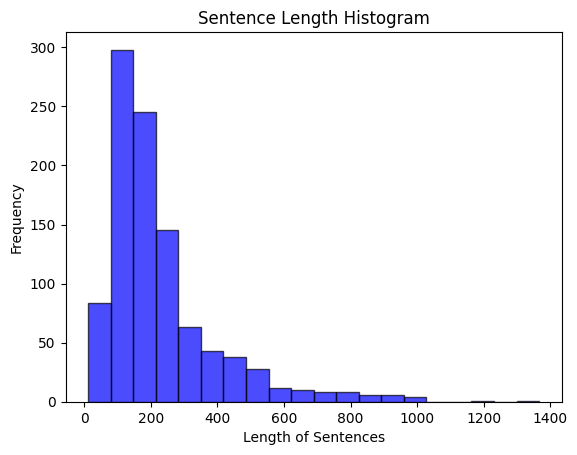

In [30]:
# cheaking for maximum length


import matplotlib.pyplot as plt

def draw_sentence_length_histogram(sentences, title='Sentence Length Histogram', xlabel='Length of Sentences', ylabel='Frequency'):
    sentence_lengths = [len(sentence.split()) for sentence in sentences]
    plt.hist(sentence_lengths, bins=20, color='blue', edgecolor='black', alpha=0.7)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


draw_sentence_length_histogram(clean_train)


In [31]:
train_token=tokenizer(clean_train,padding=True,truncation=True,max_length=250, return_tensors='pt',return_token_type_ids=False) # return_token_type_ids is false because we have one sentence only
test_token=tokenizer(clean_test,padding=True,truncation=True,max_length=250, return_tensors='pt',return_token_type_ids=False) # return_token_type_ids is false because we have one sentence only

In [32]:
train_token['input_ids'][:2]

tensor([[  101,  2033,  1998,  1037,  2767, 12524,  2023,  3185,  2138,  2009,
          5015,  2428,  2204,  2021,  2057,  2020,  3308,  2034,  1997,  1996,
          3772, 12155, 26677,  5369,  3772,  2001,  1996,  5409,  1996,  3896,
          2020,  2428,  2919,  2004,  2092,  2009,  2790,  2066,  1037,  2143,
          1037,  2267,  4845,  2081,  1996,  5436,  2001,  3492,  2204,  2021,
          2009,  2094,  2042,  2589,  1996,  2518,  2008,  9868,  1996,  5691,
          1996,  2087,  2020,  1996,  5889,  1996,  2364,  3124,  2001,  1996,
          5409,  3364,  2412, 12762,  1037,  9467, 10047,  2130,  4214,  2032,
          2019,  3364, 10760,  2069,  2204,  2518,  2055,  2023,  3185,  2001,
          2009,  2001,  2061,  2919,  2009,  2001,  6057,  6499,  2065,  2017,
          2215,  1037,  2204,  4756,  2156,  2009,  8569,  2102,  2060,  2084,
          2008,  9153,  2100,  2521,  2185,  2013,  2023,  2028,  1045,  2788,
          2293,  1038,  2862,  5691,  1998,  2107,  

In [33]:
train_token['attention_mask'][:2]

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [34]:
# creating tensor for labels
import torch
train_label=random_train_records['label']
print(train_label[:10])
train_label=torch.tensor(list(random_train_records['label']))
print(train_label[:50])

6868     0
24016    1
9668     0
13640    0
14018    0
7488     0
5804     0
12909    0
3386     0
9567     1
Name: label, dtype: int64
tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
        1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
        1, 0])


In [35]:
import torch
test_label=random_test_records['label']
print(test_label[:50])
test_label=torch.tensor(list(random_test_records['label']))
print(test_label[:50])

6868     0
24016    0
9668     1
13640    1
14018    0
7488     0
5804     0
12909    0
3386     0
9567     0
21423    0
3503     1
6657     0
19192    0
2518     0
13361    0
21135    0
21080    1
6492     0
6891     0
7752     1
8614     0
6649     0
2227     1
12060    1
19122    1
9622     1
12279    1
16447    1
423      0
14337    1
22163    1
19839    1
12456    0
10277    1
23085    1
1805     0
2790     1
24427    0
17716    0
4972     0
7613     0
17238    0
13570    1
7946     0
5100     1
23948    1
21182    1
733      0
18404    1
Name: label, dtype: int64
tensor([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
        0, 1])


In [36]:
# adding labes to train_token
train_token['labels']=train_label
test_token['labels']=test_label


In [37]:
test_token['labels'].shape,test_token['attention_mask'].shape,test_token['input_ids'].shape

(torch.Size([100]), torch.Size([100, 250]), torch.Size([100, 250]))

In [38]:
train_token['labels'].shape,train_token['attention_mask'].shape,train_token['input_ids'].shape

(torch.Size([1000]), torch.Size([1000, 250]), torch.Size([1000, 250]))

In [46]:
from transformers import AdamW
optimizer = AdamW(model.parameters(), lr=1e-5)  # Adjust learning rate as needed
criterion = torch.nn.CrossEntropyLoss()
# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
num_epochs = 1  # Adjust as needed
batch_size = 4
from tqdm.auto import tqdm
num_training_steps = int(num_epochs * 1000/4)
progress_bar = tqdm(range(num_training_steps))
for i in range(num_epochs):
    model.train()
    total_loss=0
    for j in range(0,len(train_token['labels']),batch_size):
        input_ids=train_token['input_ids'][j:j+batch_size].to(device)
        attention_mask=train_token['attention_mask'][j:j+batch_size].to(device)
        labels=train_token['labels'][j:j+batch_size].to(device)
        optimizer.zero_grad()
        output=model(input_ids=input_ids,attention_mask=attention_mask,labels=labels)
        loss=output.loss
        total_loss=total_loss+loss.item()
        loss.backward()
        optimizer.step()
        progress_bar.update(1)

    avg_loss = total_loss / (len(labels) / batch_size)
    print(f'Epoch {i + 1}, Loss: {avg_loss:.4f}')






/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1, Loss: 14.4687


In [47]:
model.eval()
total_eval_accuracy = 0
for i in range(len(clean_test)):
    input_data = tokenizer(clean_test[i], return_tensors='pt', padding=True, truncation=True).to(device)
    labels = torch.tensor(int(test_label[i])).unsqueeze(0).to(device)  # Ensure labels are integers
    with torch.no_grad():
        outputs = model(**input_data, labels=labels)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    total_eval_accuracy += (predictions == labels).item()

eval_accuracy = total_eval_accuracy / len(clean_test)
print(f"Accuracy on evaluation data: {eval_accuracy}")
# Save the model
#model.save_pretrained(model_save_path)
#tokenizer.save_pretrained(model_save_path)

# Load the model for inference
#loaded_model = BertForSequenceClassification.from_pretrained(model_save_path)
#loaded_tokenizer = BertTokenizer.from_pretrained(model_save_path)



Accuracy on evaluation data: 0.91


In [48]:
model.save_pretrained("/content/sample_data/bertfinetune.pth")

In [49]:
tokenizer.save_pretrained("/content/sample_data/tocken.json")

('/content/sample_data/tocken.json/tokenizer_config.json',
 '/content/sample_data/tocken.json/special_tokens_map.json',
 '/content/sample_data/tocken.json/vocab.txt',
 '/content/sample_data/tocken.json/added_tokens.json',
 '/content/sample_data/tocken.json/tokenizer.json')

In [51]:
# Load the model for inference
loaded_model = AutoModelForSequenceClassification.from_pretrained("/content/sample_data/bertfinetune.pth")
loaded_tokenizer = AutoTokenizer.from_pretrained("/content/sample_data/tocken.json")

In [ ]:
loaded_model.to(device)

In [68]:
# inference
text=df_train['text'][15000]
text=clean_text(text)
text_token=loaded_tokenizer(text, padding=True, truncation=True, max_length=250,return_tensors='pt').to(device)
text_pred=loaded_model(**text_token)

In [69]:
text_pred.logits

tensor([[ 0.8527, -0.9001]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [70]:
predictions = torch.nn.functional.softmax(text_pred.logits, dim=-1)
predictions

tensor([[0.8523, 0.1477]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [71]:
predictions = predictions.cpu().detach().numpy()
predictions

array([[0.8523002 , 0.14769977]], dtype=float32)

In [73]:
label=df_train['label'][15000]
label

1

In [ ]:
# using fit method and tensorflow
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split

# Assuming you have a list of texts and corresponding labels
texts = ['example text 1', 'example text 2']
labels = [0, 1]  # Assuming binary classification (0 or 1)

# Split the data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Define the model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=2) # Adjust num_labels for your specific classification task

# Tokenize the texts
train_encodings = tokenizer(train_texts, truncation=True, padding=True, return_tensors='tf')
val_encodings = tokenizer(val_texts, truncation=True, padding=True, return_tensors='tf')

# Convert labels to numpy arrays
train_labels = tf.convert_to_tensor(train_labels)
val_labels = tf.convert_to_tensor(val_labels)

# Define optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train the model with validation data
model.fit(
    x=train_encodings,
    y=train_labels,
    validation_data=(val_encodings, val_labels),
    epochs=3
)


In [1]:

# Save the model and tokenizer
model.save_pretrained('fine_tuned_bert_model')
tokenizer.save_pretrained('fine_tuned_bert_tokenizer')

# Loading the model for inference
loaded_model = TFBertForSequenceClassification.from_pretrained('fine_tuned_bert_model')
loaded_tokenizer = BertTokenizer.from_pretrained('fine_tuned_bert_tokenizer')

# Example of using the loaded model for inference
input_text = ['example text for inference']
input_encodings = loaded_tokenizer(input_text, truncation=True, padding=True, return_tensors='tf')
output = loaded_model(input_encodings)
print(output)

Note: you may need to restart the kernel to use updated packages.
